In [21]:
import lightgbm
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_validate, train_test_split, cross_val_score, cross_val_predict
import pandas as pd
import shap
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
import numpy as np
from sklearn.feature_selection import mutual_info_regression

In [22]:
df = pd.read_csv("../data/interim/sample.csv")
df1 = pd.read_csv("../data/interim/model_torchxray.csv")
df1.drop(["gt_sum", "gt_sum_pos"], axis=1, inplace=True)

In [23]:
df = pd.merge(df, df1, on="fname")

In [24]:
df["false_positive"] = ~df.true & ~df.positive_gt
df["false_negative"] = ~df.true & df.positive_gt

In [25]:
df[['iou', 'iomax', 'dice_at_tolerance']] = df[['iou', 'iomax', 'dice_at_tolerance']].fillna(1.0)
df.loc[~df.positive_gt & df.true, "iomin"] = df.loc[~df.positive_gt & df.true, "iomin"].fillna(1.0)
df["iomin"].fillna(0.0, inplace=True)

In [26]:
df.head(5)

,id,fname,sample_name,iou,iomin,iomax,dice,true,positive_gt,hausdorff,...,Mass,Hernia,Lung Lesion,Fracture,Lung Opacity,Enlarged Cardiomediastinum,No Finding,No Finding Sum,false_positive,false_negative
0,00000181_061_1,00000181_061,1,0.350949,0.985127,0.352818,0.519561,True,True,12.165525,...,0.547738,0.012142,0.139100,0.523429,0.593831,0.530269,0.398298,-8.776658,False,False
1,00000181_061_2,00000181_061,2,0.237160,1.000000,0.237160,0.383396,True,True,13.784049,...,0.547738,0.012142,0.139100,0.523429,0.593831,0.530269,0.398298,-8.776658,False,False
2,00000181_061_3,00000181_061,3,0.381895,0.587954,0.521455,0.552716,True,True,13.000000,...,0.547738,0.012142,0.139100,0.523429,0.593831,0.530269,0.398298,-8.776658,False,False
3,00013977_005_1,00013977_005,1,0.000000,0.000000,0.000000,0.000021,False,True,17.233688,...,0.584497,0.014976,0.263935,0.111970,0.065350,0.386314,0.415503,-4.553343,False,True
4,00013977_005_2,00013977_005,2,0.791545,0.930406,0.841359,0.883646,True,True,5.196152,...,0.584497,0.014976,0.263935,0.111970,0.065350,0.386314,0.415503,-4.553343,False,False


In [27]:
predictors = [col for col in df.columns if col not in ["id", "fname", "sample_name", "y", "Unnamed: 0"]]
# predictors_metrics = [pred for pred in predictors if pred in ["iou", "iomin", "iomax", "gt_sum", "gt_sum_pos", "true", "positive_gt", "false_positive", "false_negative"]]

In [28]:
fnames = list(df.fname.unique())
# fnames_train, fnames_test = train_test_split(fnames, train_size=0.8, random_state=24, shuffle=True)

In [29]:
# predictors = predictors_metrics

In [30]:
df_train = df.loc[~pd.isnull(df.y)].copy()
df_test = df = df.loc[pd.isnull(df.y)].copy()

In [31]:
df_train.corr()["y"].sort_values()

robust_hausdorff             -0.679425
dist                         -0.532196
dist_inv                     -0.513163
ncomponents_abs_diff         -0.383297
false_negative               -0.348899
hausdorff                    -0.228700
Cardiomegaly                 -0.222196
false_positive               -0.220380
No Finding                   -0.172717
area_abs_diff                -0.138702
Atelectasis                  -0.136512
sample_name                  -0.130815
hausdorff_inv                -0.121332
Fracture                     -0.098530
Edema                        -0.078394
Emphysema                    -0.067645
Hernia                       -0.049515
Effusion                     -0.047839
out_of_lungs_lr              -0.031325
Infiltration                 -0.025480
positive_gt                  -0.015859
ncomponents                  -0.010311
No Finding Sum                0.008730
Pneumothorax                  0.023859
Lung Opacity                  0.043457
Pleural_Thickening       

In [134]:
X_train = df_train[predictors].fillna(0.0)
X_train = X_train.replace([np.inf], 100000.0)
df_test[predictors] = df_test[predictors].fillna(0.0)
df_test = df_test.replace([np.inf], 100000.0)
y_train = df_train["y"]

In [73]:
corr_matrix = X_train.corr()
threshold = 0.9
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold):
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

iomax iou 0.9866099983464108
dice iou 0.9799397539257453
dice iomax 0.9802335536133366
precision_0.25 precision_0.0 0.9084102685138388
f1_0.25 f1_0.0 0.9147757689106338


In [74]:
# To be used within GridSearch (5 in your case)
inner_cv = GroupKFold(n_splits=5)

# To be used in outer CV (you asked for 10)
outer_cv = GroupKFold(n_splits=10)

In [142]:
from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin

# could not use Pipeline, sklearn doesn't allow cloning Pipelines
class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **estimator_params):
        super().__init__()
        self.selector = SelectKBest(score_func=mutual_info_regression, k="all")
        self.base_model = lightgbm.LGBMRegressor(random_state=24, objective="regression_l1")
        self.set_params(**estimator_params)

    def fit(self, X, y=None):
        X_tr = self.selector.fit_transform(X, y)
        self.base_model.fit(X_tr, y)
        return self

    def predict(self, X):
        X_tr = self.selector.transform(X)
        y = self.base_model.predict(X_tr)
        y[X.false_positive == 1] = 1
        y[X.false_negative == 1] = 1
        y[(X.area_model + X.area_expert) == 0] = 5
        y = np.round(y, 0)
        return y
    
    def get_params(self, **params):
        pars = self.base_model.get_params()
        pars["k"] = self.selector.k
        return pars
    
    def set_params(self, **params):
        if "k" in params:
            k = params.pop("k")
            self.selector = self.selector.set_params(k=k)
        self.base_model = self.base_model.set_params(**params)
        return self

In [147]:
model = CustomRegressor()
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "colsample_bytree": [0.25, 0.5, 0.75, 1.0],
    "min_child_samples": [1, 3, 5, 10],
    "num_leaves": [5, 7, 15, 31],
    #"zero_as_missing": [False, True],
    "k": [15, 30, len(predictors)],
    "lambda_l1": [0.0, 0.1, 1.0],
    # "lambda_l2": [0.0, 0.1, 1.0]
}

In [148]:
pred_y = []
true_y = []
for train_index, test_index in outer_cv.split(X_train, y_train, groups=df_train.fname):
    X_tr, X_tt = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_tr, y_tt = y_train.iloc[train_index], y_train.iloc[test_index]
    groups_tt = df_train.fname.iloc[train_index]

    clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, verbose=True, n_jobs=-1, scoring="neg_mean_absolute_error")
    clf.fit(X_tr,y_tr, groups=groups_tt)

    pred = clf.predict(X_tt)   
    pred_y.extend(pred)
    true_y.extend(y_tt)
    nested_score = metrics.mean_absolute_error(true_y, pred_y)
    nested_accuracy = metrics.accuracy_score(true_y, pred_y)
    print(nested_score, nested_accuracy)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.0min finished


0.2777777777777778 0.7222222222222222
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


0.3888888888888889 0.6111111111111112
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7734 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8684 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9734 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10884 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


0.37037037037037035 0.6481481481481481
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.1min finished


0.3472222222222222 0.6805555555555556
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


0.36666666666666664 0.6888888888888889
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


0.4444444444444444 0.6481481481481481
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


0.4444444444444444 0.6428571428571429
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 8864 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 9914 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 11064 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


0.4305555555555556 0.6458333333333334
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


0.4506172839506173 0.6296296296296297
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.4min


0.45 0.6222222222222222


[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.1min finished


In [149]:
nested_score = metrics.mean_absolute_error(true_y, pred_y)
nested_accuracy = metrics.accuracy_score(true_y, pred_y)

In [150]:
clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=-1, refit=True, verbose=True, scoring="neg_mean_absolute_error")
clf.fit(X_train, y_train, groups=df_train.fname)
non_nested_score = -clf.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 11378 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  4.4min finished


In [151]:
clf.best_params_

{'colsample_bytree': 1.0,
 'k': 15,
 'lambda_l1': 1.0,
 'min_child_samples': 5,
 'n_estimators': 200,
 'num_leaves': 7}

In [152]:
print("All predictors", nested_score, nested_accuracy, non_nested_score)

All predictors 0.45 0.6222222222222222 0.4222222222222222


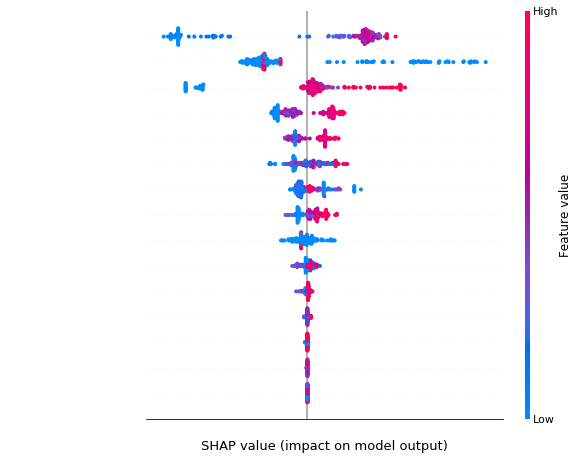

In [153]:
X_tr = clf.best_estimator_.selector.transform(X_train)
explainer = shap.TreeExplainer(clf.best_estimator_.base_model)
shap_values = explainer.shap_values(X_tr)
topk = clf.best_estimator_.selector.get_support()
shap.summary_plot(shap_values, X_tr, axis_color="white", feature_names=X_train.columns[topk])

In [154]:
model = model.set_params(**clf.best_params_)
df_train['prediction'] = cross_val_predict(model, X_train, y_train, cv=inner_cv, groups=df_train.fname)
df_test['prediction'] = clf.predict(df_test[predictors].fillna(0.0))

In [155]:
def rand_jitter(arr):
    stdev = .02 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [156]:
df_train['prediction_jitter'] = rand_jitter(df_train.prediction)

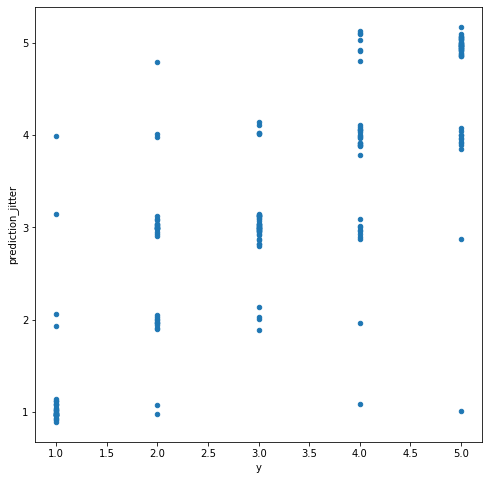

In [157]:
df_train.plot.scatter("y", "prediction_jitter", figsize=(8, 8))

In [158]:
df_train.corr()['y'].sort_values()

robust_hausdorff             -0.679425
dist                         -0.532196
dist_inv                     -0.513163
ncomponents_abs_diff         -0.383297
false_negative               -0.348899
hausdorff                    -0.228700
Cardiomegaly                 -0.222196
false_positive               -0.220380
No Finding                   -0.172717
area_abs_diff                -0.138702
Atelectasis                  -0.136512
sample_name                  -0.130815
hausdorff_inv                -0.121332
Fracture                     -0.098530
Edema                        -0.078394
Emphysema                    -0.067645
Hernia                       -0.049515
Effusion                     -0.047839
out_of_lungs_lr              -0.031325
Infiltration                 -0.025480
positive_gt                  -0.015859
ncomponents                  -0.010311
No Finding Sum                0.008730
Pneumothorax                  0.023859
Lung Opacity                  0.043457
Pleural_Thickening       

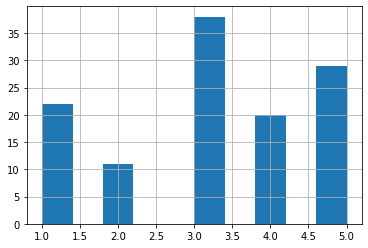

In [159]:
df_test.prediction.hist()

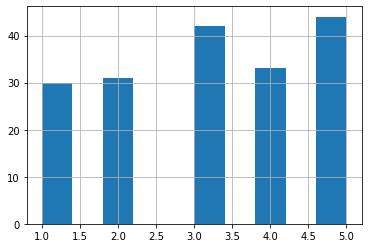

In [160]:
df_train.y.hist()

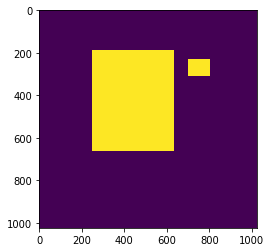

In [173]:
mask = np.zeros((1024, 1024), dtype=bool)
mask[2*94:2*(94+237), 2*124:2*(124+193)] = 1
mask[2*116:2*(116+38), 2*351:2*(351+50)] = 1
import matplotlib.pyplot as plt
plt.imshow(mask)